In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import imageio.v2 as imageio 
import io
import random

In [16]:

def init_network(N, reset_potential=-20, sandbox_size=(10,10)):
    global M, V, spikes, sizes
    
    sizes = np.random.uniform(50, 500, N)
    M = np.random.rand(N, N)  # Generate a random connectivity matrix
    M = M / np.sum(M)  # Normalize the matrix
    M = M - np.transpose(M)  # Symmetrically inhibit
    np.fill_diagonal(M,0) # no self-connections

    V = np.random.rand(N)  # Random initial membrane potentials
    spikes = np.random.rand(N) > 0.5  # Random initial spiking states
    V[spikes] = reset_potential  # If a neuron spikes initially, set its potential to -20

    fig, ax = plt.subplots()
    
    G = nx.Graph()

    # Generate random positions for neurons within the sandbox
    sandbox_width, sandbox_height = sandbox_size
    positions = {i: (random.uniform(0, sandbox_width), random.uniform(0, sandbox_height)) for i in range(N)}

    # Add nodes to the graph with random positions
    G.add_nodes_from(range(N))
    nx.set_node_attributes(G, positions, 'pos')
    
    # Draw the network
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, node_size=sizes, node_color='blue', with_labels=False, ax=ax)
    ax.axis('off')  # Turn off axis labels
    
    return M, V, spikes, positions

def simulate_network(M, V, spikes, iterations, REST=-1, leak=0.001, input_noise=170.5):
    global spiking_activity, V_list
    
    N = M.shape[0]
    spiking_activity = []  # List to store spiking states
    V_list = []  # List to store membrane potentials


    for _ in range(iterations):
        V = V + input_noise * np.dot(M, spikes) + 0.1 * (np.random.rand(N) - 0.3) - leak * V
        spikes = (V > 1)  # Neurons spike if their membrane potential exceeds 1
        V[spikes] = REST  # Reset the membrane potential of spiking neurons to the resting potential
        V[V < REST] = REST  # Ensure that membrane potentials do not fall below the resting potential
        spiking_activity.append(spikes.copy())  # Store the spiking states
        V_list.append(V.copy())  # Store the membrane potentials

    spiking_activity = np.array(spiking_activity)  # Convert to numpy array for visualization
    V_list = np.array(V_list)  # Convert to numpy array for visualization
    
    return spiking_activity, V_list


def get_firing_rates(spiking_activity, window_size):

    N = len(spiking_activity)
    firing_rates = np.zeros(N)

    for i in range(N):
        # Count spikes for the current neuron within the specified window size
        recent_spikes = spiking_activity[i][-window_size:]
        firing_rates[i] = np.sum(recent_spikes)

    # Convert counts to firing rates
    firing_rates /= window_size

    return firing_rates


def adjust_node_sizes(firing_rates, node_sizes, growth_coeff):
    global f_target
    
    for i in range(len(firing_rates)):
        if firing_rates[i] < f_target:
            node_sizes[i] += growth_coeff  # Increase node size
        else:
            node_sizes[i] -= growth_coeff  # Decrease node size
    return node_sizes



#def update_connectivity_matrix(M, node_positions, node_sizes, conn_coeff):
    N = M.shape[0]
    for i in range(N):
        for j in range(i + 1, N):
            dist = np.linalg.norm(np.array(node_positions[i]) - np.array(node_positions[j]))  # Euclidean distance between nodes
            if dist < overlap_threshold:  # If nodes overlap
                M[i, j] += conn_coeff  # Increase connectivity
                M[j, i] = -M[i, j]  # Connectivity matrix is symmetric
    return M

In [25]:
def plot_activity(spiking_activity, V_list):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(spiking_activity.T, aspect='auto', cmap='binary')
    plt.xlabel('Time')
    plt.ylabel('Neuron Index')
    plt.title('Neuron Firings Over Time')

    plt.subplot(1, 2, 2)
    plt.imshow(V_list.T, aspect='auto', cmap='seismic')
    plt.xlabel('Time')
    plt.ylabel('Neuron index')
    plt.title('Membrane Potential Over Time')
    plt.colorbar(label='Membrane Potential')

    plt.tight_layout()
    plt.show()

def get_node_colors(frame):
    colors = []
    for i, s in enumerate(spiking_activity[frame]):
        if s:
            colors.append('green')  # If the neuron is spiking, set color to red
        else:
            # Normalize membrane potential values to range [0, 1] and apply colormap
            voltage_normalized = (V_list[frame, i] - V_list.min()) / (V_list.max() - V_list.min())
            colors.append(plt.cm.seismic(voltage_normalized))
    return colors

def draw_network(positions, node_colors, node_sizes, ax):
    global N
    
    G = nx.Graph()
    G.add_nodes_from(range(N))
    nx.set_node_attributes(G, positions, 'pos')
    
    ax.set_facecolor('black')  # Set axis background color to black
    
    nx.draw(G, positions, node_size=node_sizes, node_color=node_colors, with_labels=False, ax=ax)

    ax.set_aspect('equal')  # Ensure equal aspect ratio
    ax.axis('off')  # Turn off axis labels

def generate_animation(f_name = 'animation.gif', duration=0.1):
    # Create the subplot
    global positions, iterations, V_list, spiking_activity, sizes
    fig, ax = plt.subplots(facecolor='black')

    # Create a list to store the frames
    frames = []

    # Iterate over each frame and generate it
    for i in range(iterations):

        # Update colors for the current frame
        colors = get_node_colors(i)

        # Clear previous plot
        ax.clear()

        # Plot the network with updated node colors
        draw_network(positions, colors, sizes, ax)

        # Convert the current figure to an image
        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        buf.seek(0)

        # Read the image from the buffer and append it to the list of frames
        frames.append(imageio.imread(buf))

    # Save the frames as an animated GIF
    animation_file = f_name
    imageio.mimsave(animation_file, frames, duration=duration)

    plt.close(fig)  # Close the figure to free up memory

    # Display a message indicating the completion of GIF creation
    print(f"Animation saved as '{animation_file}'")

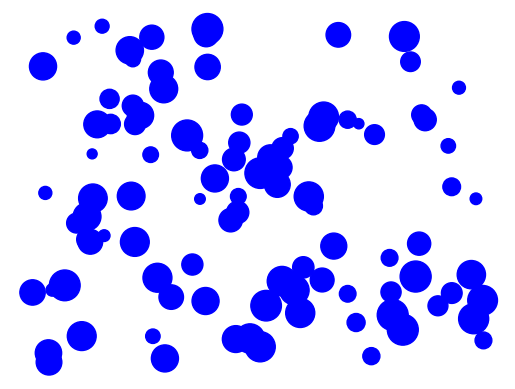

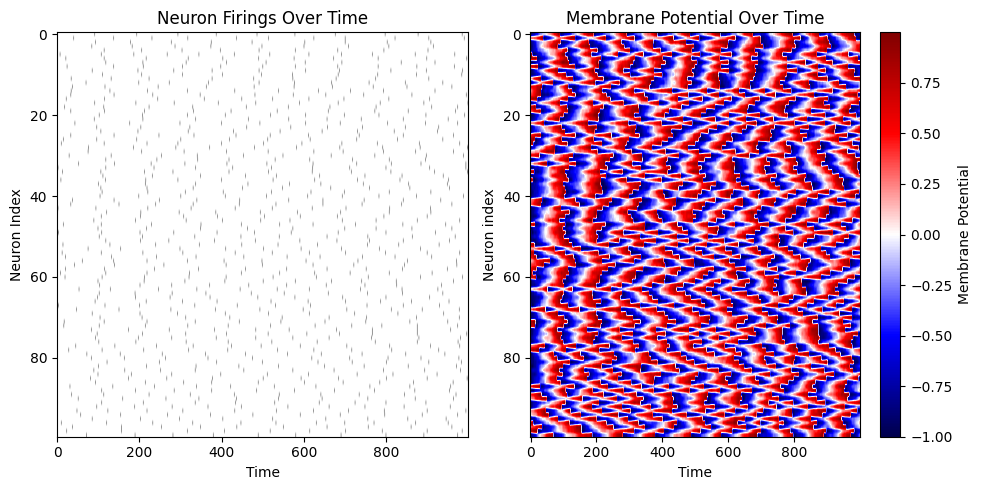

Animation saved as 'test.gif'


In [27]:
N = 100  
iterations = 1000

M, V, spikes, positions = init_network(N)
spiking_activity, V_list = simulate_network(M, V, spikes, iterations, input_noise = 50)

plot_activity(spiking_activity, V_list)

generate_animation('test.gif')
